In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from numpy import median
import numpy.ma as ma
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from scipy import signal 
import cPickle as pkl
from lab.classes.dbclasses import dbMouse
from scipy.ndimage.interpolation import shift
import itertools as it
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
%run Helper_Functions.ipynb

In [ ]:
mouseList = ['bv119', 'bv125', 'bv132', 'bv135', 'bv136', 'bv138', 'bv140', 'bv142', 'bv143']

allData = []
for mouseID in mouseList:
    print(mouseID), 
    labels = pd.read_excel('/data2/bert/CA3/Histology/Subtypes.xlsx', sheet_name = mouseID)
    
    exptList = [expt for expt in dbMouse(mouseID).imagingExperiments() if \
                expt.experimentType != 'rippleActivity']
    dataBuffer = []
    for expt in exptList:
        print expt.experimentType
        if ('all_fissa' or 'all') in expt.labels(): 
            if expt.hasDfofTracesFile():  
                subtype_id = ROI_planeID(expt, 'all_fissa') 
                roi_label = 'all_fissa'
                
                imData = np.squeeze(expt.imagingData(dFOverF = 'from_file', label = roi_label))
                velocity = expt.velocity(smoothing = 'hanning', window_length = 5)[0]
                
                for roiID in xrange(imData.shape[0]): 
                    cell_data = imData[roiID, :]
                    corr_coef, lag = calculate_Cross_Correlation(expt, cell_data, velocity, \
                                    number_of_lag_seconds = 3)
                    dataBuffer.append({'expt': expt.trial_id,
                                    'Subtype': labels['Subtype'][subtype_id[roiID]], 
                                    'Layer': labels['Layer'][subtype_id[roiID]],
                                    'Corr_Coef': corr_coef, 
                                    'Lag': lag, 
                                    'Region': labels['Region'][subtype_id[roiID]],
                                    'Imaging_Plane': subtype_id[roiID], 
                                    'SATB1': labels['SATB1'][subtype_id[roiID]]})
    
    dataBuffer = pd.DataFrame(dataBuffer)
    for planenumber in filter(lambda v: v==v, np.unique(dataBuffer['Imaging_Plane'])):
        corr_coef_mean = np.nanmean(dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Corr_Coef'])
        lag_mean = np.nanmean(dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Lag'])
        
        allData.append({'mouseID': mouseID, 
                'Layer': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Layer'].iloc[0],
                'Subtype': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Subtype'].iloc[0], 
                'Corr_Coef': corr_coef_mean, 
                'Lag': lag_mean, 
                'Region': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['Region'].iloc[0],
                'SATB1': dataBuffer[dataBuffer.Imaging_Plane == planenumber]['SATB1'].iloc[0]})
                             
                    
allData = pd.DataFrame(allData)

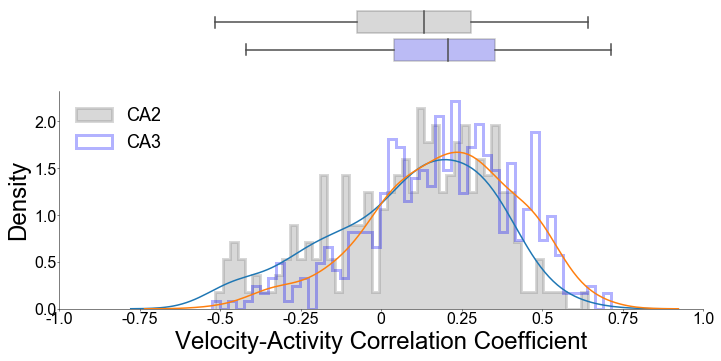

In [5]:
fig = plt.figure(figsize = (10, 5))
gs = gridspec.GridSpec(4, 1, figure = fig)

SMALL_SIZE = 6
MEDIUM_SIZE = 7
BIGGER_SIZE = 9
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

fig_ax1 = fig.add_subplot(gs[0:1,:])
my_palette = {'CA2': 'gray', 'CA3': 'blue'}
sns.boxplot(x = 'Corr_Coef', y = 'Region', data = allData, \
            showfliers = False, palette = my_palette, boxprops = dict(alpha = 0.3), ax = fig_ax1)
fig_ax1.set_xlim([-1,1])
fig_ax1.axis('off')
fig_ax2 = fig.add_subplot(gs[1:,:], sharex = fig_ax1)
sns.distplot(allData[allData.Region == 'CA2'].Corr_Coef.values, \
             bins = 50, hist = True, kde = True, \
             hist_kws = {"linewidth": 3, "alpha": 0.3, "color": "gray", "fill": True, \
                        "histtype": "step"}, label = 'CA2', ax = fig_ax2) 
sns.distplot(allData[allData.Region == 'CA3'].Corr_Coef.values, \
             bins = 50, hist = True, kde = True, \
             hist_kws = {"linewidth": 3, "alpha": 0.3, "color": "blue", "fill": False, \
                        "histtype": "step"}, label = 'CA3', ax = fig_ax2) 
fig_ax2.legend(fontsize = 18, frameon = False)
fig_ax2.tick_params(axis = 'x', labelsize = 16)
fig_ax2.tick_params(axis = 'y', labelsize = 16)
fig_ax2.set_xlabel('Velocity-Activity Correlation Coefficient', fontsize = 24)
fig_ax2.set_xticklabels([-1.00, -0.75, -0.50, -0.25, 0, 0.25, 0.50, 0.75, 1.00], fontsize = 20)
fig_ax2.set_xlim([-1,1])
#fig_ax2.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], fontsize = 20)
fig_ax2.set_ylabel('Density', fontsize = 24)
simpleaxis(fig_ax2)

fig.tight_layout()
plt.savefig('Velocity_Corr_Coef_by_Region.svg', transparent = True)

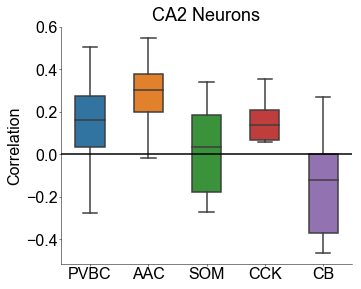

In [17]:
CA2_data = allData[allData.Region == 'CA2']
subtypes = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
order = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
CA2_data = CA2_data[CA2_data.Subtype.isin(subtypes)]

fig, ax = plt.subplots(1,1,figsize = (5,4))
sns.boxplot(x = 'Subtype', y = 'Corr_Coef', data = CA2_data, order = order, \
            width = 0.5, showfliers = False, ax = ax)
ax.set_xlabel('')
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_ylabel('Correlation', fontsize = 16)
ax.set_title('CA2 Neurons', fontsize = 18)
ax.axhline(y = 0, color = 'black')
simpleaxis(ax)

fig.tight_layout()
plt.savefig('CA2_Corr_w_Velocity_by_Subtype.svg', transparent = True)

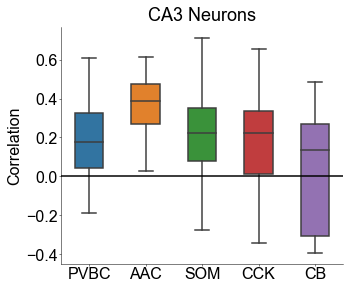

In [38]:
CA3_data = allData[allData.Region == 'CA3']
subtypes = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
order = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
CA3_data = CA3_data[CA3_data.Subtype.isin(subtypes)]

fig, ax = plt.subplots(1,1,figsize = (5,4))
sns.boxplot(x = 'Subtype', y = 'Corr_Coef', data = CA3_data, order = order, \
            width = 0.5, showfliers = False, ax = ax)
ax.set_xlabel('')
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_ylabel('Correlation', fontsize = 16)
ax.set_title('CA3 Neurons', fontsize = 18)
ax.axhline(y = 0, color = 'black')
simpleaxis(ax)

fig.tight_layout()
plt.savefig('CA3_Corr_w_Velocity_by_Subtype.svg', transparent = True)